In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import torch

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
# CSV 파일에 접근
maml_info = pd.read_csv('../MAML_filter64/MAML_filter64_inner_loop.csv')
arbiter_info = pd.read_csv('../MAML+Arbiter_5way_5shot_filter64_7108/MAML+Arbiter_5way_5shot_filter64_inner_loop.csv')

# 훈련 정보만 가지고 온다
maml_info_train = maml_info[maml_info['phase']=='train']
arbiter_info_train= arbiter_info[arbiter_info['phase']=='train']

C:\Users\JM\anaconda3\envs\maml\lib\site-packages\IPython\core\interactiveshell.py:3553: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# 1. 정보를 Domain 별로 압축

In [3]:
# mini-imagenet
arbiter_info_mini_imagenet = arbiter_info[arbiter_info['current_iter']=='mini_imagenet_full_size']
arbiter_info_mini_imagenet = arbiter_info_mini_imagenet.groupby('num_step')
# tiered-imagenet
arbiter_info_tiered_imagenet = arbiter_info[arbiter_info['current_iter']=='tiered_imagenet']
arbiter_info_tiered_imagenet = arbiter_info_tiered_imagenet.groupby('num_step')
# CIFAR_FS
arbiter_info_CIFAR_FS = arbiter_info[arbiter_info['current_iter']=='CIFAR_FS']
arbiter_info_CIFAR_FS = arbiter_info_CIFAR_FS.groupby('num_step')
# CUB
arbiter_info_CUB = arbiter_info[arbiter_info['current_iter']=='CUB']
arbiter_info_CUB = arbiter_info_CUB.groupby('num_step')

# 2. Box plot으로 Domain 별로 비교

ValueError: List of boxplot statistics and `positions` values must have same the length

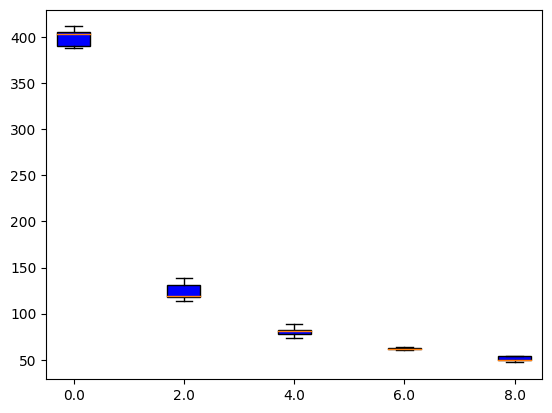

In [4]:
# 이상치 제거 함수 정의
def remove_outliers(group):
    Q1 = group.quantile(0.25)
    Q3 = group.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return group[(group >= lower_bound) & (group <= upper_bound)]

group_names = []
filtered_values_1 = []
filtered_values_2 = []

for name, group in arbiter_info_mini_imagenet:
    group_values = group['layer_dict.conv3.conv.weight_alpha']
    #group_values = remove_outliers(group_values)
    filtered_values_1.append(group_values)
    
    # 그룹 이름을 저장 (모든 그룹은 동일한 순서로 추가됨)
    if name not in group_names:
        group_names.append(name)
        
for name, group in arbiter_info_CUB:
    group_values = group['layer_dict.conv3.conv.weight_alpha']
    #group_values = remove_outliers(group_values)
    filtered_values_2.append(group_values)

    
# 두 개의 박스플롯을 같은 x축에 그리기 위해 위치 조정
positions_1 = [i * 2.0 for i in range(len(filtered_values_1))]
positions_2 = [i * 2.0 + 0.8 for i in range(len(filtered_values_2))]



# 첫 번째 박스플롯
plt.boxplot(filtered_values_1, positions=positions_1, widths=0.6, patch_artist=True,
            boxprops=dict(facecolor='blue'), showfliers=False)

# 두 번째 박스플롯
plt.boxplot(filtered_values_2, positions=positions_2, widths=0.6, patch_artist=True,
            boxprops=dict(facecolor='red'), showfliers=False)

# x축 라벨 설정
plt.xticks([i * 2.0 + 0.4 for i in range(len(group_names))], group_names)

# 그래프 라벨 및 제목 설정
plt.xlabel('Inner-loop step')
plt.ylabel('Values')
plt.title('Conv-3 Gradient Norm')

# 그래프를 표시합니다
plt.show()

# 2. 그래프로 비교

In [5]:
arbiter_info_mini_imagenet_mean_df = arbiter_info_mini_imagenet['all_grads_l2norm'].mean()
arbiter_info_mini_imagenet_variance_df = arbiter_info_mini_imagenet['all_grads_l2norm'].var()
arbiter_info_mini_imagenet_std_dev_df = arbiter_info_mini_imagenet_variance_df**0.5

# 그룹 이름과 평균 및 표준 편차를 리스트로 추출합니다
arbiter_info_mini_imagene_group_names = arbiter_info_mini_imagenet_mean_df.index.tolist()
maml_means = arbiter_info_mini_imagenet_mean_df.values
maml_std_devs = maml_std_dev_df.values

arbiter_mean_df = arbiter_per_inner_loop_step['all_grads_l2norm'].mean()
arbiter_variance_df = arbiter_per_inner_loop_step['all_grads_l2norm'].var()
arbiter_std_dev_df = arbiter_variance_df**0.5

# 그룹 이름과 평균 및 표준 편차를 리스트로 추출합니다
arbiter_group_names = arbiter_mean_df.index.tolist()
arbiter_means = arbiter_mean_df.values
arbiter_std_devs = arbiter_std_dev_df.values


# x축 값을 생성합니다
x = range(len(maml_group_names))

# 꺾은선 그래프를 그립니다
plt.figure(figsize=(10, 6))
plt.plot(x, maml_means, '-o', color='b', label='MAML')
plt.plot(x, arbiter_means, '-o', color='r', label='Arbiter')

# 표준 편차 범위를 그림자로 표시합니다
plt.fill_between(x, maml_means - maml_std_devs, maml_means + maml_std_devs, color='b', alpha=0.2, label='Standard Deviation')
plt.fill_between(x, arbiter_means - arbiter_std_devs, arbiter_means + arbiter_std_devs, color='r', alpha=0.2, label='Standard Deviation')

plt.xticks(x, group_names)
plt.xlabel('Inner-loop step')
plt.ylabel('value')
plt.title('Gradeitn norm')

# 격자무늬 추가
plt.grid(True)

# # y축을 로그 스케일로 설정
# plt.yscale('log')

# 그래프를 표시합니다
plt.show()

NameError: name 'maml_std_dev_df' is not defined